<a href="https://colab.research.google.com/github/smaugcow/test_test/blob/main/lab2_byob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import logging

In [2]:
SEED = 3236
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

logging.basicConfig(format="[%(asctime)s] %(levelname)s: %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class BYOLTransform:
    def __init__(self):
        self.augment = T.Compose([
            T.RandomResizedCrop(32),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.RandomGrayscale(p=0.2),
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    def __call__(self, x):
        return self.augment(x), self.augment(x)

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=BYOLTransform())
full_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

train_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=True, drop_last=True, worker_init_fn=lambda _: np.random.seed(SEED))
test_loader = DataLoader(full_test_dataset, batch_size=256, shuffle=False, worker_init_fn=lambda _: np.random.seed(SEED))

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


In [4]:
def get_encoder():
    resnet = resnet18(weights=None)
    resnet.fc = nn.Identity()
    resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    return nn.Sequential(resnet, nn.Flatten())

dummy_encoder = get_encoder()
dummy_encoder.eval()
with torch.no_grad():
    dummy_output = dummy_encoder(torch.randn(1, 3, 32, 32))
feature_dim = dummy_output.shape[1]

In [5]:
class MLPHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        return self.fc(x)

In [6]:
class BYOL(nn.Module):
    def __init__(self, base_encoder, feature_dim, projection_dim=256, ema_decay=0.99):
        super().__init__()
        self.online_encoder = base_encoder()
        self.online_projector = MLPHead(feature_dim, projection_dim)
        self.online_predictor = MLPHead(projection_dim, projection_dim)
        self.target_encoder = base_encoder()
        self.target_projector = MLPHead(feature_dim, projection_dim)
        self.ema_decay = ema_decay
        self._update_target(0)

    def forward(self, x1, x2):
        z1_online = self.online_projector(self.online_encoder(x1))
        z2_online = self.online_projector(self.online_encoder(x2))
        p1 = self.online_predictor(z1_online)
        p2 = self.online_predictor(z2_online)
        with torch.no_grad():
            z1_target = self.target_projector(self.target_encoder(x1)).detach()
            z2_target = self.target_projector(self.target_encoder(x2)).detach()
        return p1, p2, z1_target, z2_target

    def loss_fn(self, x, y):
        x = F.normalize(x, dim=-1)
        y = F.normalize(y, dim=-1)
        return 2 - 2 * (x * y).sum(dim=-1).mean()

    def training_step(self, x1, x2):
        p1, p2, z1, z2 = self(x1, x2)
        return self.loss_fn(p1, z2) + self.loss_fn(p2, z1)

    def _update_target(self, decay=None):
        if decay is None:
            decay = self.ema_decay
        for t, o in zip(self.target_encoder.parameters(), self.online_encoder.parameters()):
            t.data = decay * t.data + (1 - decay) * o.data
        for t, o in zip(self.target_projector.parameters(), self.online_projector.parameters()):
            t.data = decay * t.data + (1 - decay) * o.data

In [7]:
def extract_features(encoder, loader):
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            if isinstance(x, (list, tuple)):
                x = x[0]
            x = x.to(device)
            f = encoder(x).cpu().numpy()
            features.append(f)
            labels.append(y.numpy())
    return np.vstack(features), np.hstack(labels)

def flatten_images(loader):
    all_x, all_y = [], []
    for x, y in loader:
        if isinstance(x, (list, tuple)):
            x = x[0]
        all_x.append(x.view(x.size(0), -1).numpy())
        all_y.append(y.numpy())
    return np.vstack(all_x), np.hstack(all_y)

In [8]:
logging.info("Подготовка baseline (сырые пиксели)...")
raw_train_x, raw_train_y = flatten_images(train_loader)
raw_test_x, raw_test_y = flatten_images(test_loader)

model = BYOL(get_encoder, feature_dim=feature_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

byol_losses = []

In [9]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for (x1, x2), _ in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        loss = model.training_step(x1, x2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model._update_target()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    byol_losses.append(avg_loss)
    logging.info(f"Epoch {epoch+1}/{epochs} — BYOL Loss: {avg_loss:.4f}")

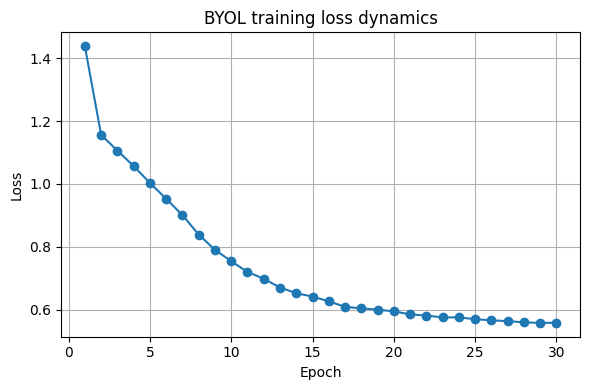

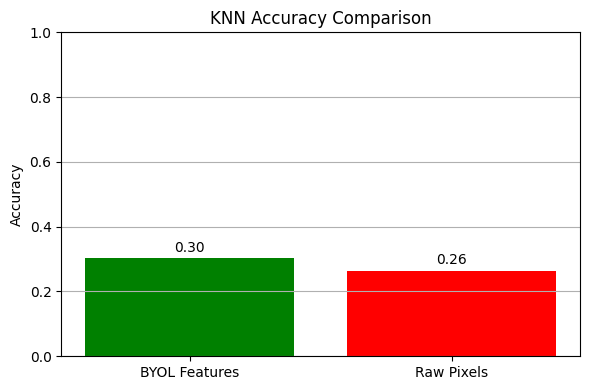

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs+1), byol_losses, marker="o")
plt.title("BYOL training loss dynamics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

logging.info("Извлечение признаков и KNN классификация...")
feats_train, lbls_train = extract_features(model.online_encoder, train_loader)
feats_test, lbls_test = extract_features(model.online_encoder, test_loader)

scaler_feat = StandardScaler()
feats_train_scaled = scaler_feat.fit_transform(feats_train)
feats_test_scaled = scaler_feat.transform(feats_test)

knn_feat = KNeighborsClassifier(n_neighbors=5)
knn_feat.fit(feats_train_scaled, lbls_train)
preds_feat = knn_feat.predict(feats_test_scaled)
acc_feat = accuracy_score(lbls_test, preds_feat)
logging.info(f"KNN по признакам BYOL: Accuracy = {acc_feat:.4f}")

scaler_raw = StandardScaler()
raw_train_scaled = scaler_raw.fit_transform(raw_train_x)
raw_test_scaled = scaler_raw.transform(raw_test_x)

knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(raw_train_scaled, raw_train_y)
preds_raw = knn_raw.predict(raw_test_scaled)
acc_raw = accuracy_score(raw_test_y, preds_raw)
logging.info(f"KNN по пикселям: Accuracy = {acc_raw:.4f}")

plt.figure(figsize=(6, 4))
methods = ['BYOL Features', 'Raw Pixels']
accuracies = [acc_feat, acc_raw]
colors = ['green', 'red']

plt.bar(methods, accuracies, color=colors)
plt.title('KNN Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()